In [235]:
%matplotlib inline

# Package and dataset loading

In [236]:
import torch
import torchvision
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [237]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [238]:
# Load GOOG stock data

path = 'data/stock_market_data/GOOG.csv'
data = pd.read_csv(path)

data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104,2.640104


C:\Users\irfan\AppData\Local\Temp\ipykernel_2240\87753547.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_goog['Date'] = pd.to_datetime(data_goog['Date'])


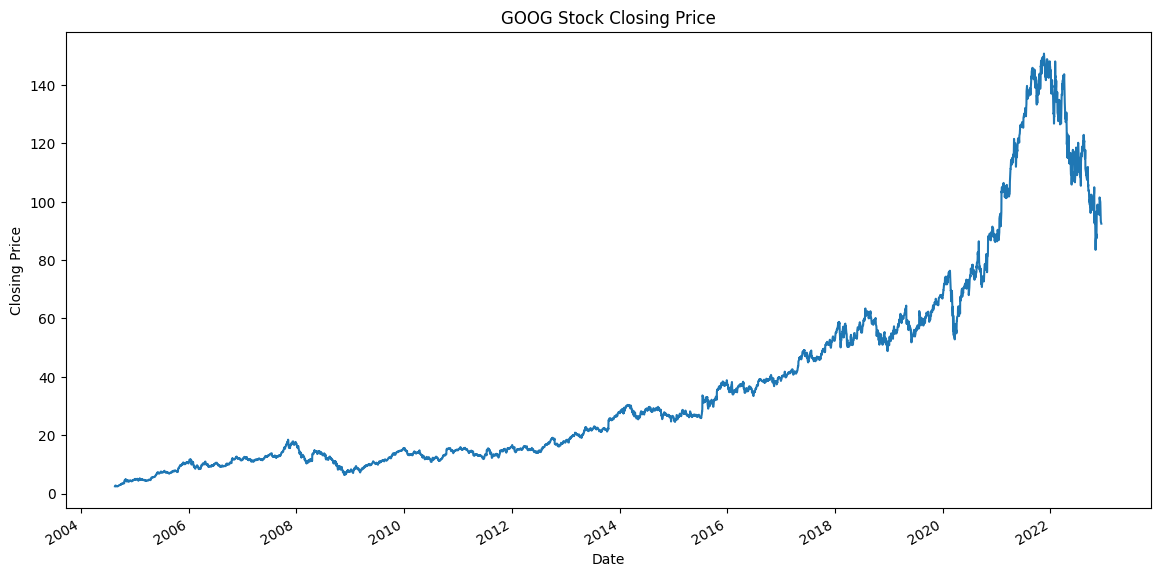

In [239]:
# Draw the stock price closing price plot
data_goog = data.copy()

data_goog['Date'] = pd.to_datetime(data_goog['Date'])
data_goog.set_index('Date', inplace=True)

# Plot the closing price with dates as x-axis
data_goog['Close'].plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('GOOG Stock Closing Price')
plt.show()

# Data scaling

In [240]:
# Data preprocessing

from sklearn.preprocessing import MinMaxScaler
price = data[['Close']].copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

# Train test val split

In [241]:
# Split data into training and test set with sliding window method

def split_data(stock, lookback, val_size=0.1):
    data_raw = stock.to_numpy()  # Convert to numpy array
    data = []

    # Create sequences of length `lookback`
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    val_set_size = int(np.round(val_size * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size + val_set_size)

    # Split into training, validation, and test sets
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size+val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size+val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:, :-1, :]
    y_test = data[train_set_size+val_set_size:, -1, :]

    return x_train, y_train, x_val, y_val, x_test, y_test

lookback = 20 # choose sequence length
x_train, y_train, x_val, y_val, x_test, y_test = split_data(price, lookback)

# Check shapes
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_val.shape =', x_val.shape)
print('y_val.shape =', y_val.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (3215, 19, 1)
y_train.shape = (3215, 1)
x_val.shape = (459, 19, 1)
y_val.shape = (459, 1)
x_test.shape = (918, 19, 1)
y_test.shape = (918, 1)


In [242]:
# Convert to tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
y_val_rnn = torch.from_numpy(y_val).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_val_lstm = torch.from_numpy(y_val).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
y_val_gru = torch.from_numpy(y_val).type(torch.Tensor)

# Create a TensorDataset and DataLoader
# def get_data_loader(X, y, batch_size=32):
#     dataset = TensorDataset(X, y)
#     return DataLoader(dataset=dataset, batch_size=32, shuffle=True)

# Param values
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

# Build RNN model

In [243]:
# Define RNN
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out
    
# Create the model
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Train RNN model

In [244]:
# Train the model
import time

def train_model(model, 
                criterion, 
                optimiser, 
                x_train, y_train,
                x_val=None, y_val=None, 
                num_epochs = 100):
    train_loss = []
    val_loss = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        optimiser.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
        
        if x_val is not None:
            model.eval()
            with torch.no_grad():
                val_outputs = model(x_val)
                val_epoch_loss = criterion(val_outputs, y_val)
                val_loss.append(val_epoch_loss.item())
        else:
            val_loss.append(None)
            
        if epoch % 10 == 0:
            if x_val is not None:
                print(f'Epoch {epoch}, train loss: {loss.item()}, val loss: {val_epoch_loss.item()}')
            else:
                print(f'Epoch {epoch}, train loss: {loss.item()}')
    
    training_time = time.time() - start_time
    print(f'Training time: {training_time}')
    
    return train_loss, val_loss
    

In [245]:
train_loss_rnn, val_loss_rnn = train_model(model, 
                                           criterion, 
                                           optimiser,
                                           x_train, y_train_rnn,
                                           x_val = x_val, y_val = y_val_rnn,
                                           num_epochs = num_epochs)

Epoch 0, train loss: 0.7598881125450134, val loss: 0.051157549023628235
Epoch 10, train loss: 0.052208591252565384, val loss: 0.3363806903362274
Epoch 20, train loss: 0.022732576355338097, val loss: 0.28338536620140076
Epoch 30, train loss: 0.017343292012810707, val loss: 0.17227141559123993
Epoch 40, train loss: 0.015312819741666317, val loss: 0.13460691273212433
Epoch 50, train loss: 0.01159195601940155, val loss: 0.10908528417348862
Epoch 60, train loss: 0.00560054462403059, val loss: 0.03160419687628746
Epoch 70, train loss: 0.0005142752779647708, val loss: 0.004091346170753241
Epoch 80, train loss: 0.0026482432149350643, val loss: 0.01620977558195591
Epoch 90, train loss: 0.0005689816316589713, val loss: 0.006108846049755812
Training time: 2.888916254043579


# RNN model evaluation

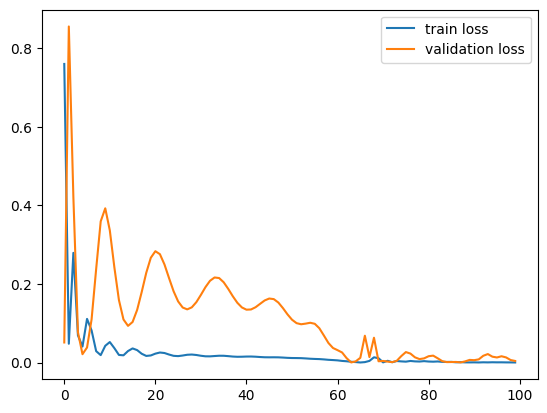

In [246]:
# Display loss graph
plt.plot(train_loss_rnn, label='train loss')
plt.plot(val_loss_rnn, label='validation loss')
plt.legend()
plt.show()

In [247]:
# Do evaluation on test and print MSE value
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)
    mse = criterion(y_test_pred, y_test_rnn)
    print(f'MSE on test set: {mse.item()}')


MSE on test set: 0.026605946943163872


In [248]:
# Descale the data and use date as index
y_test_pred_goog = scaler.inverse_transform(y_test_pred)
y_test_rnn_goog = scaler.inverse_transform(y_test_rnn)
y_test_pred_goog = pd.DataFrame(y_test_pred_goog, index=data_goog.index[-y_test_pred_goog.shape[0]:])
y_test_rnn_goog = pd.DataFrame(y_test_rnn_goog, index=data_goog.index[-y_test_rnn_goog.shape[0]:])

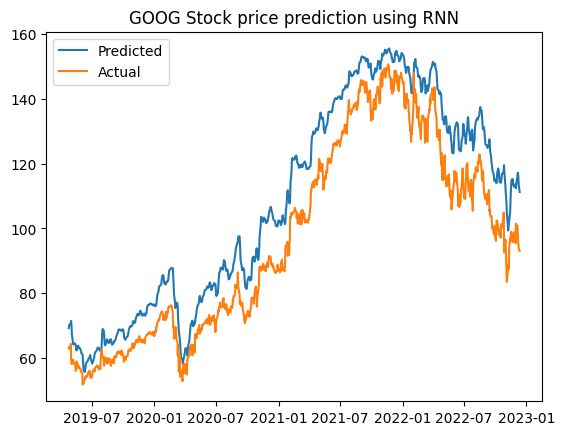

In [249]:
# Display stock price prediction vs data
plt.plot(y_test_pred_goog, label="Predicted")
plt.plot(y_test_rnn_goog, label="Actual")
plt.title('GOOG Stock price prediction using RNN')
plt.legend()
plt.show()

# Build LSTM model

In [250]:
# Define LSTM
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
# Create the model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Train LSTM model

In [251]:
train_loss_lstm, val_loss_lstm = train_model(model,
                                            criterion,
                                            optimiser,
                                            x_train, y_train_lstm,
                                            x_val = x_val, y_val = y_val_lstm,
                                            num_epochs = num_epochs)

Epoch 0, train loss: 0.5820222496986389, val loss: 0.014742588624358177
Epoch 10, train loss: 0.04560272395610809, val loss: 0.12146031111478806
Epoch 20, train loss: 0.019615210592746735, val loss: 0.22070445120334625
Epoch 30, train loss: 0.01783693954348564, val loss: 0.20872727036476135
Epoch 40, train loss: 0.016820354387164116, val loss: 0.18476350605487823
Epoch 50, train loss: 0.01533376332372427, val loss: 0.18917958438396454
Epoch 60, train loss: 0.006443898193538189, val loss: 0.05972302332520485
Epoch 70, train loss: 0.0026074484921991825, val loss: 0.037849556654691696
Epoch 80, train loss: 0.0009797991951927543, val loss: 0.0029483111575245857
Epoch 90, train loss: 0.0005561633734032512, val loss: 0.011530973948538303
Training time: 5.17248797416687


# LSTM model evaluation

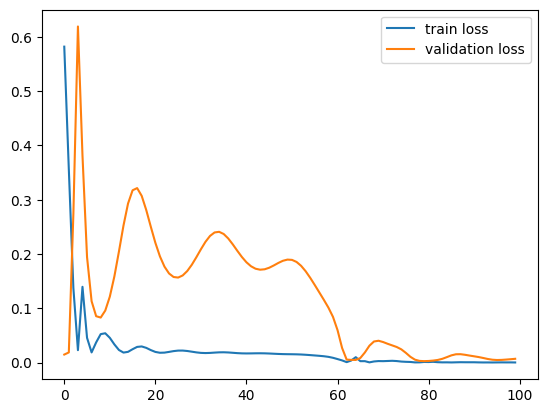

In [252]:
# Display loss graph
plt.plot(train_loss_lstm, label='train loss')
plt.plot(val_loss_lstm, label='validation loss')
plt.legend()
plt.show()

In [253]:
# Do evaluation on test and print MSE value
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)
    mse = criterion(y_test_pred, y_test_rnn)
    print(f'MSE on test set: {mse.item()}')


MSE on test set: 0.3934807777404785


In [254]:
# Descale the data and use date as index
y_test_pred_goog = scaler.inverse_transform(y_test_pred)
y_test_lstm_goog = scaler.inverse_transform(y_test_lstm)
y_test_pred_goog = pd.DataFrame(y_test_pred_goog, index=data_goog.index[-y_test_pred_goog.shape[0]:])
y_test_lstm_goog = pd.DataFrame(y_test_lstm_goog, index=data_goog.index[-y_test_lstm_goog.shape[0]:])

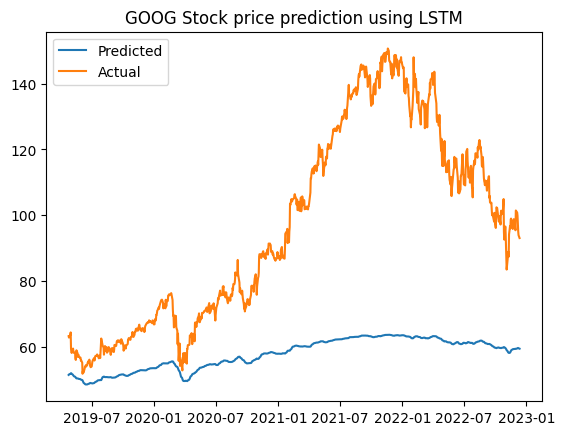

In [255]:
# Display stock price prediction vs data
plt.plot(y_test_pred_goog, label="Predicted")
plt.plot(y_test_lstm_goog, label="Actual")
plt.title('GOOG Stock price prediction using LSTM')
plt.legend()
plt.show()